<a href="https://colab.research.google.com/github/deebuls/deep_evidential_regression_loss_pytorch/blob/master/examples/example_dataset_experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/deebuls/deep_evidential_regression_loss_pytorch -q

In [2]:
import numpy as np
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(1)    # reproducible

## import loss function

In [8]:
from deep_evidential_regression_loss_pytorch import EvidentialLossSumOfSquares

## Create Dataset 

Paper experiment 1

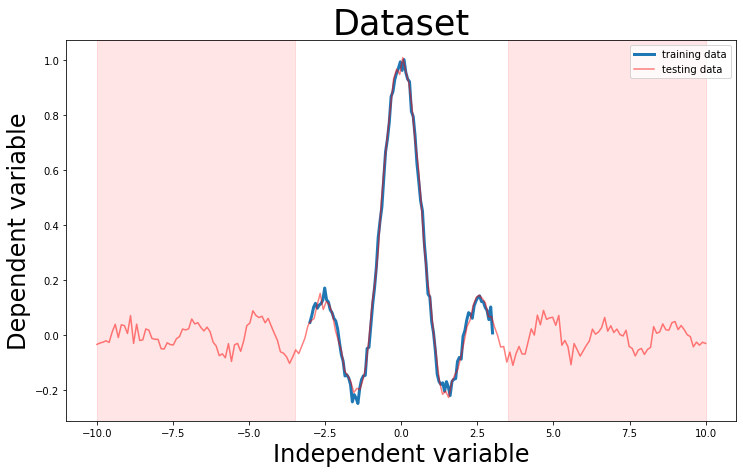

In [4]:
#hide_input
x_lim=[-10,10]; y_lim=[-1.25, 2.25]
x = torch.unsqueeze(torch.linspace(-3, 3, 100), dim=1)  # x data (tensor), shape=(100, 1)
test_x = torch.unsqueeze(torch.linspace(-10, 10, 200), dim=1)  # x data (tensor), shape=(100, 1)
y = torch.sin( 3 * x) / (3 * x )+  torch.normal(0, 0.02,size=x.size())                 # noisy y data (tensor), shape=(100, 1)
test_y = (torch.sin( 3 * test_x) / (3 * test_x )) +  torch.normal(0, 0.02,size=test_x.size())                 # noisy y data (tensor), shape=(100, 1)
fig, ax = plt.subplots(figsize=(12,7))
plt.cla()
ax.set_title('Dataset', fontsize=35)
ax.set_xlabel('Independent variable', fontsize=24)
ax.set_ylabel('Dependent variable', fontsize=24)
ax.plot(x,y, linewidth=3, label='training data')
ax.plot(test_x, test_y, color='red', alpha=0.5, label='testing data')
ax.legend( )
ax.axvspan(x_lim[0], -3.5, alpha=0.1, color='red')
ax.axvspan(3.5, x_lim[1], alpha=0.1, color='red')
# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)
test_x, test_y = Variable(test_x), Variable(test_y)

## Plotting prediction with the uncertainty

In [6]:
#hide
def plot_prediction(x, y, prediction, sigma=0.01, e=0.01):
  x_lim=[-10,10]; y_lim=[-1.25, 2.25]
  p = prediction.view(-1).data.numpy()
  x = x.view(-1).data.numpy()
  y = y.view(-1).data.numpy()
  if not type(sigma) == float:
    sigma = sigma.view(-1).data.numpy()

  if not type(e) == float:
    e = e.view(-1).data.numpy()
    

  # plot and show learning process
  fig, ax = plt.subplots(figsize=(12,7))
  plt.cla()
  ax.set_title('Regression Analysis', fontsize=35)
  ax.set_xlabel('Independent variable', fontsize=24)
  ax.set_ylabel('Dependent variable', fontsize=24)
  ax.set_xlim(x_lim[0], x_lim[1])
  ax.set_ylim(y_lim[0], y_lim[1])
  ax.axvspan(x_lim[0], -3.5, alpha=0.1, color='blue')
  ax.axvspan(3.5, x_lim[1], alpha=0.1, color='blue')
  ax.scatter(x, y, color = "orange")
  ax.plot(x, p, 'g-', lw=3, alpha=0.8)
  
  ax.fill_between(x, p + 2*sigma,p - 2*sigma, color='gray', alpha=0.3)
  if not type(e) == float:
    ax.fill_between(x, p +e, p-e, color='gray', alpha=0.3)
  #ax.plot(x.data.numpy(), (prediction - 2*sigma).data.numpy(), 'gray', alpha=0.5)
  #ax.plot(x.data.numpy(), (prediction + 2*sigma).data.numpy(), 'gray', alpha=0.5)
  #ax.axvline(-3.5, alpha=0.5)
  
  #ax.axvline(3.5, alpha=0.5)
  ax.text(1.0, 0.5, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
  ax.text(1.0, 0, 'Loss = %.4f' % loss.data.numpy(),
          fontdict={'size': 24, 'color':  'red'})

## Define Deep Nerual Network architecture

In [7]:
# this is one way to define a network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
      
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden_2 = torch.nn.Linear(n_hidden, n_hidden)
        self.hidden_3 = torch.nn.Linear(n_hidden, n_hidden)
        #self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.predict = torch.nn.Linear(n_hidden, 1)   # output layer
        self.predict_probability = torch.nn.Linear(n_hidden, 3)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(self.hidden_2(x))      # activation function for hidden layer
        x = F.relu(self.hidden_3(x))      # activation function for hidden layer
        #out = self.predict(x)
        out_value = self.predict(x)             # linear output
        out_probability = torch.abs(self.predict_probability(x))
        out = torch.cat((out_value, out_probability), dim=1)

        return out

## Train the network

In [27]:

evnet = Net(n_feature=1, n_hidden=7, n_output=4)     # define the network
print(evnet)  # net architecture
optimizer = torch.optim.Adam(evnet.parameters(), lr=0.0001)
loss_func = EvidentialLossSumOfSquares() 



Net(
  (hidden): Linear(in_features=1, out_features=7, bias=True)
  (hidden_2): Linear(in_features=7, out_features=7, bias=True)
  (hidden_3): Linear(in_features=7, out_features=7, bias=True)
  (predict): Linear(in_features=7, out_features=1, bias=True)
  (predict_probability): Linear(in_features=7, out_features=3, bias=True)
)


tensor(1.9857, grad_fn=<MeanBackward0>)
tensor(0.9587, grad_fn=<MeanBackward0>)
tensor(0.5419, grad_fn=<MeanBackward0>)
tensor(0.2418, grad_fn=<MeanBackward0>)
tensor(0.0526, grad_fn=<MeanBackward0>)
tensor(-0.0255, grad_fn=<MeanBackward0>)
tensor(-0.0795, grad_fn=<MeanBackward0>)
tensor(-0.1198, grad_fn=<MeanBackward0>)


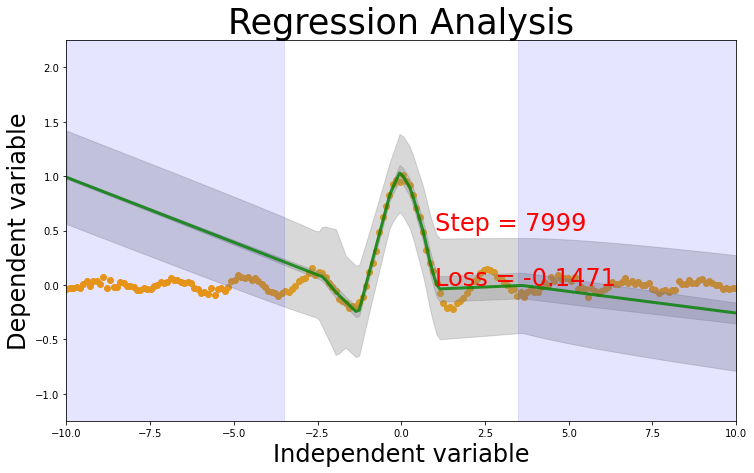

In [28]:

# train the network
for t in range(8000):
  
    prediction = evnet(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    if t%1000 == 0: print(loss)



prediction = evnet(test_x)
mu = prediction[:,0].view(-1) #first column is mu,delta, predicted value
a = prediction[:,1].view(-1) + 1.0 #alpha
b = prediction[:,2].view(-1) + 0.1 #beta
l = prediction[:,3].view(-1) + 1.0 #lamda

#a = torch.exp(a); b = torch.exp(b); l = torch.exp(l)
var = b / ((a -1)*l) #epistemic/ model/prediciton uncertaitnty
e = b / (a - 1) # aleatoric uncertainty/ data uncertainty
plot_prediction(test_x, test_y, mu, var, e)